In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False
from PIL import Image

In [2]:
import mglearn
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve


from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer

In [3]:
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default") # 경고문 다시 뜨도록

In [4]:
from sklearn.tree import export_graphviz
import graphviz

# 1. 투표(Voting)의 유형

- https://blog.naver.com/fbfbf1/222484365132

- Soft Voting
    - 각 분류기의 0과 1의 예측 확률을 평균을 내어 그 평균 값으로 최종 결과를 산출
    
- Hard Voting
    - 각 분류기의 예측 결과만을 참고하여 최종 예측 값을 산출

# 2. 종류
- Bagging
    - Bootstrap Aggresgating
    - 중첩될 수 있는 서로 다른 데이터셋에서 각각의 분류기가 모두 같은 유형의 알고리즘을 기반으로 사용되는 방식
    - 학습 데이터에 대해 여러 개의 Bootstrap 데이터를 생성하고 각 부트스트랩 데이터에 여러 알고리즘을 학습시킨 후 산출된 결과 중 투표방식에 의해 최종 결과를 산정
    - RandomForest는 일반화된 Bagging 방식이다
- Boosting
    - 학습기를 순차적으로 학습-예측을 진행한다.
    - 여러 개의 분류기가 순차적으로 학습을 하되 학습한 분류기가 틀린 데이터에 대해서 올바르게 예측할 수 있도록 다음 분류기에서 가중치를 부여
    - 단점
        - 과적합으로 인해 일반화가 어렵다.
        - 파라미터 튜닝이 까다롭다
        - 수행시간이 오래 걸린다
    - 종류
        - AdaBoost
        - GradientBoost
            - GradientBoostMachine(GBM)
            - XGBoost
            - LightGBM
- Stacking
    - 여러 학습기에서 예측한 예측값(Predict Value)을 다시 학습 데이터로 하여 일반화된 최종모델을 구성하는 방법
    

# 3. Voting 실습

## (1) Classification (분류)

### 1) 예제1

In [5]:
X_train = pd.read_csv("data/X_final_C.csv")
X_test = pd.read_csv("data/test_final_C.csv")
y_train = pd.read_csv("data/y_train_C.csv")
y_test = pd.read_csv("data/y_test_C.csv")

- hard voting

In [6]:
?VotingClassifier

In [7]:
logit_model = LogisticRegression(random_state=42)
rnf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42)

# KNN, Linear등 아무거나 추가해도 ㄱㅊ

voting_hard = VotingClassifier(estimators = [('lr', logit_model),
                                             ('rf', rnf_model),
                                             ('svc', svm_model)], voting="hard")
# estimator = ('임의의 이름', 학습모델)

voting_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [8]:
for clf in (logit_model, rnf_model, svm_model, voting_hard):
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7638190954773869
RandomForestClassifier 0.7721943048576214
SVC 0.7688442211055276
VotingClassifier 0.7738693467336684


In [9]:
##### LogisticRegression 훈련 데이터 오차 행렬

print(confusion_matrix(y_train, logit_model.predict(X_train)))

print("----------------------")

##### LogisticRegression 테스트 데이터 오차 행렬

print(confusion_matrix(y_test, logit_model.predict(X_test)))

[[832  61]
 [255 242]]
----------------------
[[354  30]
 [111 102]]


In [10]:
##### RandomForest 훈련 데이터 오차 행렬

print(confusion_matrix(y_train, rnf_model.predict(X_train)))

print("----------------------")

##### RandomForest 테스트 데이터 오차 행렬

print(confusion_matrix(y_test, rnf_model.predict(X_test)))

[[867  26]
 [ 74 423]]
----------------------
[[334  50]
 [ 86 127]]


In [11]:
##### svm 훈련 데이터 오차 행렬
print(confusion_matrix(y_train, svm_model.predict(X_train)))

print("----------------------")
##### svm 테스트 데이터 오차 행렬
print(confusion_matrix(y_test, svm_model.predict(X_test)))

[[860  33]
 [253 244]]
----------------------
[[362  22]
 [116  97]]


- soft voting(soft learner라고도 함)

In [12]:
logit_model2 = LogisticRegression(random_state=42)
rnf_model2 = RandomForestClassifier(random_state=42)
svm_model2 = SVC(probability=True, random_state=42) # soft voting은 probability=True를 켜줘야함, 확률값으로 계산하기 위해

# KNN, Linear등 아무거나 추가해도 괜찮다

voting_soft = VotingClassifier(estimators = [('lr', logit_model2),
                                             ('rf', rnf_model2),
                                             ('svc', svm_model2)], voting="soft")
# estimator = ('임의의 이름', 학습모델)

voting_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [13]:
for clf in (logit_model2, rnf_model2, svm_model2, voting_soft):
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.7638190954773869
RandomForestClassifier 0.7721943048576214
SVC 0.7688442211055276
VotingClassifier 0.7839195979899497


In [14]:
##### LogisticRegression 훈련 데이터 오차 행렬

print(confusion_matrix(y_train, logit_model2.predict(X_train)))

print("----------------------")

##### LogisticRegression 테스트 데이터 오차 행렬

print(confusion_matrix(y_test, logit_model2.predict(X_test)))

[[832  61]
 [255 242]]
----------------------
[[354  30]
 [111 102]]


In [15]:
##### svm 훈련 데이터 오차 행렬
print(confusion_matrix(y_train, svm_model2.predict(X_train)))

print("----------------------")
##### svm 테스트 데이터 오차 행렬
print(confusion_matrix(y_test, svm_model2.predict(X_test)))

[[860  33]
 [253 244]]
----------------------
[[362  22]
 [116  97]]


## (2) Regression (회귀)

### 1) 예제1

In [16]:
X_train = pd.read_csv("data/X_final_R.csv")
X_test = pd.read_csv("data/test_final_R.csv")
y_train = pd.read_csv("data/y_train_R.csv")
y_test = pd.read_csv("data/y_test_R.csv")

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [18]:
# 회귀는 hard voting, soft voting이 없다
# 회귀에서는 분류가 아니기 때문에. 무언가를 선택하는 것이 아니기 때문에.
linear_model = LinearRegression()
rnf_model = RandomForestRegressor(random_state=42)

voting_regressor = VotingRegressor(estimators=[('lr', linear_model), ('rf', rnf_model)])

voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf', RandomForestRegressor(random_state=42))])

In [19]:
#voting_regressor.predict(X_train)
print(voting_regressor.score(X_train, y_train))
print(voting_regressor.score(X_test, y_test))

0.8210012955876166
0.6239084076325578


In [20]:
# RMSE
from sklearn.metrics import mean_squared_error

pred_train = voting_regressor.predict(X_train)
MSE_train = mean_squared_error(y_train, pred_train)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_train))

pred_test = voting_regressor.predict(X_test)
MSE_test = mean_squared_error(y_test, pred_test)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_test))

훈련 데이터 RMSE :  53.046634874015865
훈련 데이터 RMSE :  77.53831029380439


# 4. Bagging 실습

In [21]:
X_train = pd.read_csv("data/X_final_C.csv")
X_test = pd.read_csv("data/test_final_C.csv")
y_train = pd.read_csv("data/y_train_C.csv")
y_test = pd.read_csv("data/y_test_C.csv")

In [22]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [23]:
model = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0)

model.fit(X_train, y_train)

BaggingClassifier(base_estimator=SVC(), random_state=0)

In [24]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7942446043165468
0.7654941373534339


In [25]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [26]:
print("훈련 데이터의 오차행렬\n", confusion_matrix(y_train, pred_train))

훈련 데이터의 오차행렬
 [[861  32]
 [254 243]]


In [27]:
print("테스트 데이터의 오차행렬\n", confusion_matrix(y_test, pred_test))

테스트 데이터의 오차행렬
 [[361  23]
 [117  96]]


In [28]:
print("훈련데이터의 분류예측 레포트\n", classification_report(y_train, pred_train))

훈련데이터의 분류예측 레포트
               precision    recall  f1-score   support

           0       0.77      0.96      0.86       893
           1       0.88      0.49      0.63       497

    accuracy                           0.79      1390
   macro avg       0.83      0.73      0.74      1390
weighted avg       0.81      0.79      0.78      1390



In [29]:
print("테스트 데이터의 분류예측 레포트\n", classification_report(y_test, pred_test))

테스트 데이터의 분류예측 레포트
               precision    recall  f1-score   support

           0       0.76      0.94      0.84       384
           1       0.81      0.45      0.58       213

    accuracy                           0.77       597
   macro avg       0.78      0.70      0.71       597
weighted avg       0.77      0.77      0.75       597



## (2) Regression(회귀)

In [30]:
X_train = pd.read_csv("data/X_final_R.csv")
X_test = pd.read_csv("data/test_final_R.csv")
y_train = pd.read_csv("data/y_train_R.csv")
y_test = pd.read_csv("data/y_test_R.csv")

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor

In [32]:
model = BaggingRegressor(base_estimator=KNeighborsRegressor(), n_estimators=10, random_state=0)

model.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(), random_state=0)

In [33]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7096886277992998
0.5833223330736411


In [34]:
pred_train = model.predict(X_train)
MSE_train = mean_squared_error(y_train, pred_train)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_train))

pred_test = model.predict(X_test)
MSE_test = mean_squared_error(y_test, pred_test)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_test))

훈련 데이터 RMSE :  67.55615433565438
훈련 데이터 RMSE :  81.61493370530255


# 5. Boosting 실습

## (1) Classification (분류)

### 1) AdaBoosting

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [36]:
X_train = pd.read_csv("data/X_final_C.csv")
X_test = pd.read_csv("data/test_final_C.csv")
y_train = pd.read_csv("data/y_train_C.csv")
y_test = pd.read_csv("data/y_test_C.csv")

In [37]:
model = AdaBoostClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [38]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [39]:
print("훈련 데이터의 오차행렬\n", confusion_matrix(y_train, pred_train))
print("--------------------------------------------")
print("테스트 데이터의 오차행렬\n", confusion_matrix(y_test, pred_test))

훈련 데이터의 오차행렬
 [[873  20]
 [230 267]]
--------------------------------------------
테스트 데이터의 오차행렬
 [[372  12]
 [108 105]]


In [40]:
print("훈련데이터의 분류예측 레포트\n", classification_report(y_train, pred_train))
print("--------------------------------------------")
print("테스트 데이터의 분류예측 레포트\n", classification_report(y_test, pred_test))

훈련데이터의 분류예측 레포트
               precision    recall  f1-score   support

           0       0.79      0.98      0.87       893
           1       0.93      0.54      0.68       497

    accuracy                           0.82      1390
   macro avg       0.86      0.76      0.78      1390
weighted avg       0.84      0.82      0.81      1390

--------------------------------------------
테스트 데이터의 분류예측 레포트
               precision    recall  f1-score   support

           0       0.78      0.97      0.86       384
           1       0.90      0.49      0.64       213

    accuracy                           0.80       597
   macro avg       0.84      0.73      0.75       597
weighted avg       0.82      0.80      0.78       597



### 2) GradientBoosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                  max_depth=1, random_state=0)
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [43]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8244604316546763
0.8056951423785594


In [44]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [45]:
print("훈련 데이터의 오차행렬\n", confusion_matrix(y_train, pred_train))
print("--------------------------------------------")
print("테스트 데이터의 오차행렬\n", confusion_matrix(y_test, pred_test))

훈련 데이터의 오차행렬
 [[871  22]
 [222 275]]
--------------------------------------------
테스트 데이터의 오차행렬
 [[371  13]
 [103 110]]


In [46]:
print("훈련데이터의 분류예측 레포트\n", classification_report(y_train, pred_train))
print("--------------------------------------------")
print("테스트 데이터의 분류예측 레포트\n", classification_report(y_test, pred_test))

훈련데이터의 분류예측 레포트
               precision    recall  f1-score   support

           0       0.80      0.98      0.88       893
           1       0.93      0.55      0.69       497

    accuracy                           0.82      1390
   macro avg       0.86      0.76      0.78      1390
weighted avg       0.84      0.82      0.81      1390

--------------------------------------------
테스트 데이터의 분류예측 레포트
               precision    recall  f1-score   support

           0       0.78      0.97      0.86       384
           1       0.89      0.52      0.65       213

    accuracy                           0.81       597
   macro avg       0.84      0.74      0.76       597
weighted avg       0.82      0.81      0.79       597



## (2) Regression

In [47]:
X_train = pd.read_csv("data/X_final_R.csv")
X_test = pd.read_csv("data/test_final_R.csv")
y_train = pd.read_csv("data/y_train_R.csv")
y_test = pd.read_csv("data/y_test_R.csv")

### 1) AdaBoosting

In [48]:
from sklearn.ensemble import AdaBoostRegressor

In [49]:
model = AdaBoostRegressor(n_estimators=100, random_state=0)

model.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100, random_state=0)

In [50]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.29695728654825215
0.27200565799961796


In [51]:
pred_train = model.predict(X_train)
MSE_train = mean_squared_error(y_train, pred_train)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_train))

훈련 데이터 RMSE :  105.12929466476501


In [52]:
pred_test = model.predict(X_test)
MSE_test = mean_squared_error(y_test, pred_test)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_test))

훈련 데이터 RMSE :  107.87815798537731


### 2) GradientBoosting

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
model = GradientBoostingRegressor(random_state=0)

model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [55]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6971712683907527
0.6168063010725628


In [56]:
pred_train = model.predict(X_train)
MSE_train = mean_squared_error(y_train, pred_train)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_train))

훈련 데이터 RMSE :  68.99719473408665


In [57]:
pred_test = model.predict(X_test)
MSE_test = mean_squared_error(y_test, pred_test)
print("훈련 데이터 RMSE : ", np.sqrt(MSE_test))

훈련 데이터 RMSE :  78.26700222894027


## (3) Breast Cancer Sample

In [94]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=11, test_size=.2)

In [95]:
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [96]:
X_train

array([[1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       [1.231e+01, 1.652e+01, 7.919e+01, ..., 8.660e-02, 2.618e-01,
        7.609e-02],
       [1.163e+01, 2.929e+01, 7.487e+01, ..., 6.835e-02, 2.884e-01,
        7.220e-02],
       ...,
       [1.877e+01, 2.143e+01, 1.229e+02, ..., 2.048e-01, 3.679e-01,
        9.870e-02],
       [1.537e+01, 2.276e+01, 1.002e+02, ..., 1.476e-01, 2.556e-01,
        6.828e-02],
       [1.145e+01, 2.097e+01, 7.381e+01, ..., 6.127e-02, 2.762e-01,
        8.851e-02]])

In [97]:
y_train

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,

### 1) GradientBoostingClassifier

In [98]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [99]:
model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)

In [100]:
model = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.9912280701754386


In [101]:
model = GradientBoostingClassifier(random_state=42)

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.9912280701754386


In [102]:
model = GradientBoostingClassifier(random_state=0, max_depth=1).fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.989010989010989
0.9736842105263158


In [103]:
model = GradientBoostingClassifier(random_state=0, max_depth=0.01).fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6175824175824176
0.6666666666666666


<AxesSubplot:>

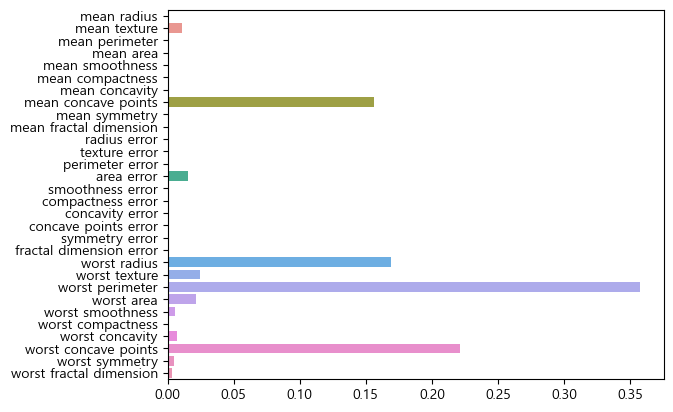

In [104]:
model = GradientBoostingClassifier(random_state=0, max_depth=1).fit(X_train, y_train)

sns.barplot(x=model.feature_importances_, y=cancer.feature_names)

In [106]:
# params = {
#     "n_estimators" : [100, 200, 300],
#     "max_depth" : [2,3,4,5,6,7,8,9],
#     "min_samples_leaf" : [1,2,3,4,5],
#     "min_samples_split" : [4, 8, 10, 11, 12, 13, 14],
#     "learning_rate" : [0.1, 0.01, 0.01, 1.0]
# }

# grid_clf = GridSearchCV(model, param_grid=params, cv=3, n_jobs=-1) # n_jobs = cpu를 몇개 쓸 것이냐 # -1 = 모든cpu
# grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(max_depth=1, random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.01, 1.0],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [4, 8, 10, 11, 12, 13, 14],
                         'n_estimators': [100, 200, 300]})

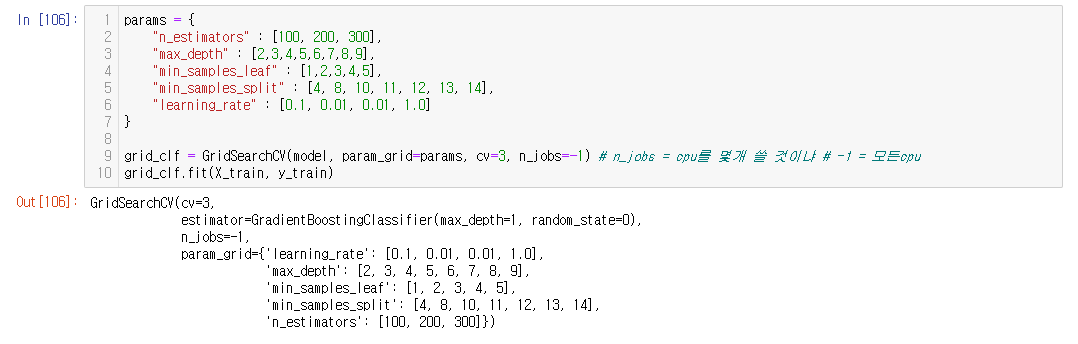

In [131]:
image = Image.open('C:/kimhotak13/PythonWork/AI/data/p1.png')
image

In [107]:
#grid_clf.best_params_

{'learning_rate': 1.0,
 'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 13,
 'n_estimators': 100}

In [108]:
# print(grid_clf.score(X_train, y_train))
# print(grid_clf.score(X_test, y_test))

0.9934065934065934
0.956140350877193


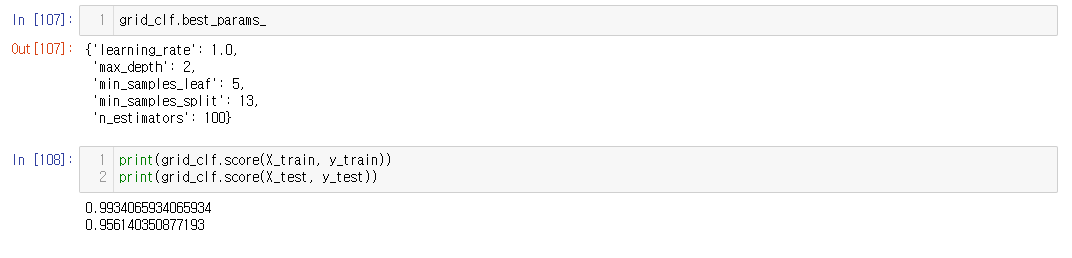

In [132]:
image = Image.open('C:/kimhotak13/PythonWork/AI/data/p2.png')
image

### 2) XGBoost
- 트리 기반의 앙상블 방식
- 분류에 있어서는 다른 알고리즘보다 좋은 예측 성능
- 병렬 cpu환경에서는 빠르게 학습이 가능
- conda install -c anaconda py-xgboost

In [113]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree

In [114]:
model = XGBClassifier(random_state=0, learning_rate=0.1, max_depth=3).fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.9824561403508771


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

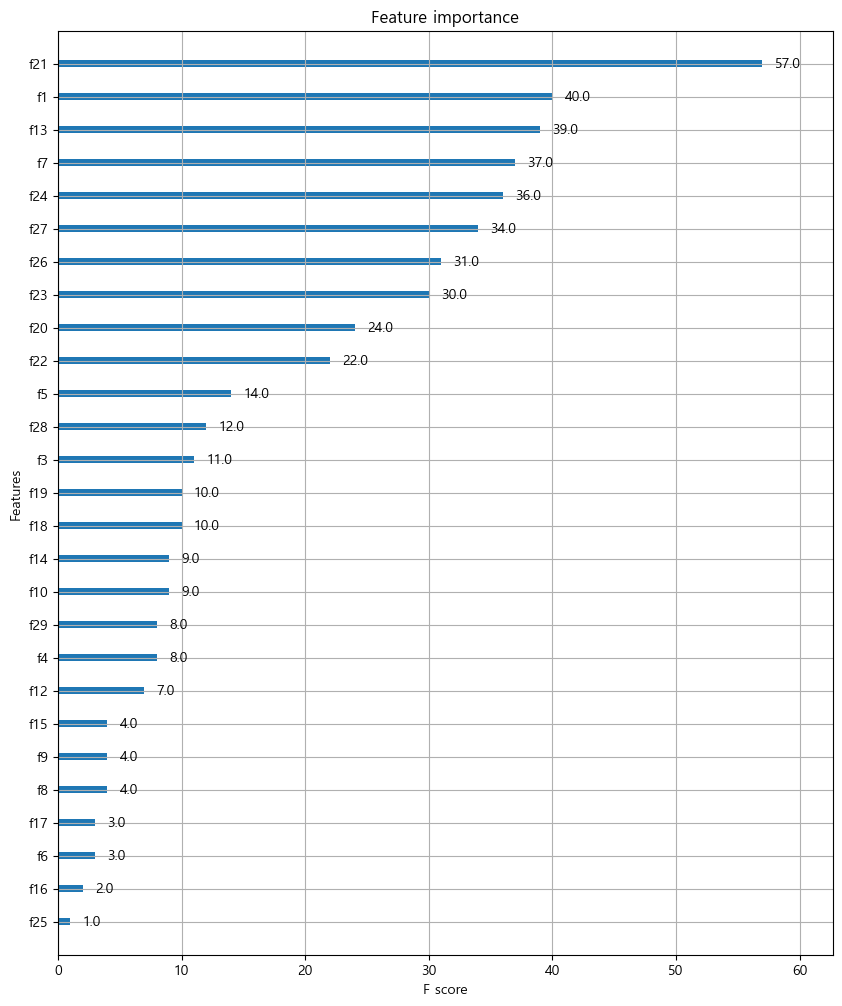

In [118]:
_, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)

In [116]:
##### 적합도 검정

cross_val = cross_validate(estimator=model, X=X_train, y=y_train, cv=5)
cross_val

print(cross_val["test_score"].mean(), cross_val["test_score"].std())

0.9626373626373625 0.020381579110979577


- California 주택

In [119]:
from sklearn.datasets import fetch_california_housing

In [124]:
california = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(california.data, california.target, random_state=42)

In [125]:
pd.DataFrame(california.data).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20640 non-null  float64
 1   1       20640 non-null  float64
 2   2       20640 non-null  float64
 3   3       20640 non-null  float64
 4   4       20640 non-null  float64
 5   5       20640 non-null  float64
 6   6       20640 non-null  float64
 7   7       20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [126]:
model1 = LinearRegression().fit(X_train, y_train)

print(model1.score(X_train, y_train))
print(model1.score(X_test, y_test))

0.6098730310529251
0.5910509795491355


In [128]:
model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective = "reg:squarederror")

model2.fit(X_train, y_train)

print(model2.score(X_train, y_train))
print(model2.score(X_test, y_test))

0.8055193255064026
0.781331812032128


- 당뇨병 샘플

In [129]:
from sklearn.datasets import load_diabetes

In [134]:
diabets = load_diabetes()
print(diabets.feature_names)
print(diabets.target)
print(diabets.keys())

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
[151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144.  97. 168.  68.  49.  68. 245. 184. 202. 137.  85.
 131. 283. 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.
  61.  92. 259.  53. 190. 142.  75. 142. 155. 225.  59. 104. 182. 128.
  52.  37. 170. 170.  61. 144.  52. 128.  71. 163. 150.  97. 160. 178.
  48. 270. 202. 111.  85.  42. 170. 200. 252. 113. 143.  51.  52. 210.
  65. 141.  55. 134.  42. 111.  98. 164.  48.  96.  90. 162. 150. 279.
  92.  83. 128. 102. 302. 198.  95.  53. 134. 144. 232.  81. 104.  59.
 246. 297. 258. 229. 275. 281. 179. 200. 200. 173. 180.  84. 121. 161.
  99. 109. 115. 268. 274. 158. 107.  83. 103. 272.  85. 280. 336. 281.
 118. 317. 235.  60. 174. 259. 178. 128.  96. 126. 288.  88. 292.  71.
 197. 186.  25.  84.  96. 195.  53. 217. 172. 131. 214.  59.  70. 220.
 268. 152.  47.  74. 295. 101. 151. 127. 237. 225.  81. 151. 107.  64.
 138. 185. 26

In [135]:
X_train, X_test, y_train, y_test = train_test_split(diabets.data, diabets.target, random_state=42)

In [136]:
model1 = LinearRegression().fit(X_train, y_train)

print(model1.score(X_train, y_train))
print(model1.score(X_test, y_test))

0.5190348343200994
0.48490866359058016


In [137]:
model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, objective = "reg:squarederror")

model2.fit(X_train, y_train)

print(model2.score(X_train, y_train))
print(model2.score(X_test, y_test))

0.8388731097716509
0.4462980077909693


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

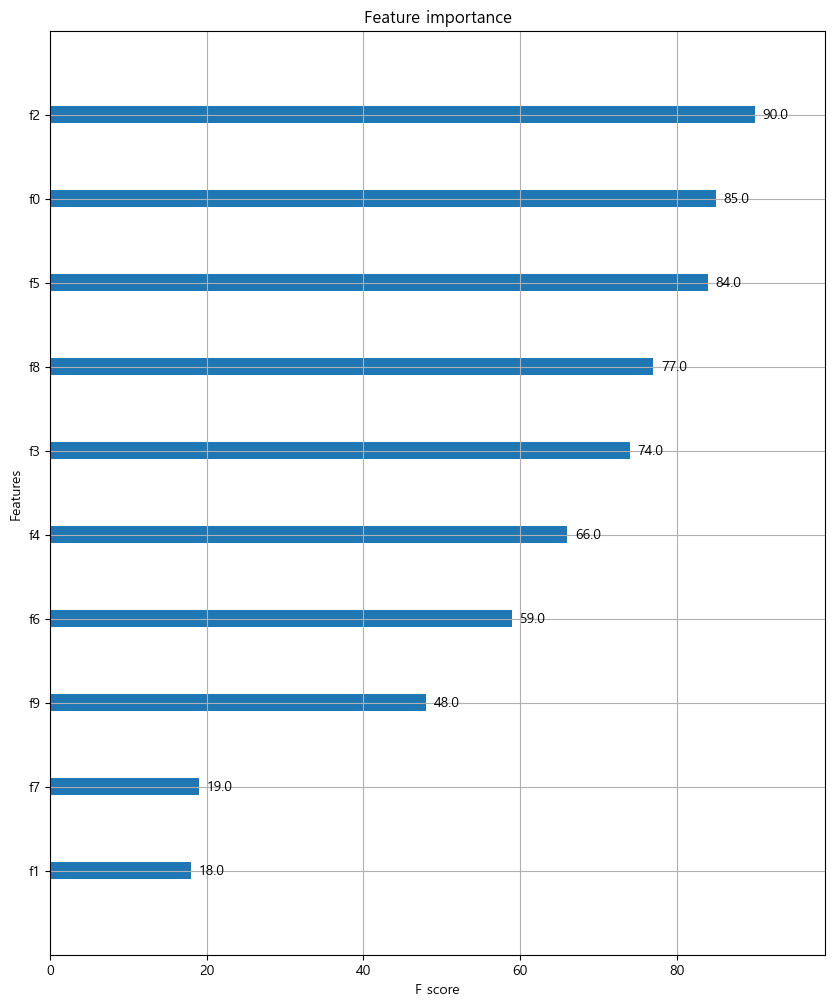

In [140]:
_, ax = plt.subplots(figsize=(10, 12))
plot_importance(model2, ax=ax)

In [141]:
# 적합도 검정
cross_val = cross_validate(estimator=model2, X=X_train, y=y_train, cv=5)
cross_val

print(cross_val["test_score"].mean(), cross_val["test_score"].std())

0.35163125058498046 0.14790313234085625


### 3) LightGBM
   - 빠른 학습시간과 예측 시간
   - 더 적은 메모리
   - pip install lightgbm

In [144]:
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric

In [163]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                   iris.target,
                                                   random_state=123,
                                                   test_size=0.2)

In [169]:
model = LGBMClassifier(n_estimators=10)
model.fit(X_train, y_train, early_stopping_rounds=100,
          eval_metric="logloss", eval_set=[(X_test, y_test)],
         verbose = True)
# fit이라는 함수 안에는 사실 반복문처럼 반복실행을 하고 있다
# 어느정도 변화가 없을 때 중지를 시키기 위한 옵션 = early_stopping_rounds
# early_stopping_rounds=100 : 100번 돌 때까지 변화가 없으면 중지시키겠다

[1]	valid_0's multi_logloss: 0.95847
[2]	valid_0's multi_logloss: 0.832184
[3]	valid_0's multi_logloss: 0.731164
[4]	valid_0's multi_logloss: 0.641056
[5]	valid_0's multi_logloss: 0.571726
[6]	valid_0's multi_logloss: 0.507286
[7]	valid_0's multi_logloss: 0.454933
[8]	valid_0's multi_logloss: 0.410205
[9]	valid_0's multi_logloss: 0.372194
[10]	valid_0's multi_logloss: 0.333919


LGBMClassifier(n_estimators=10)

In [170]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9666666666666667
0.9333333333333333


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

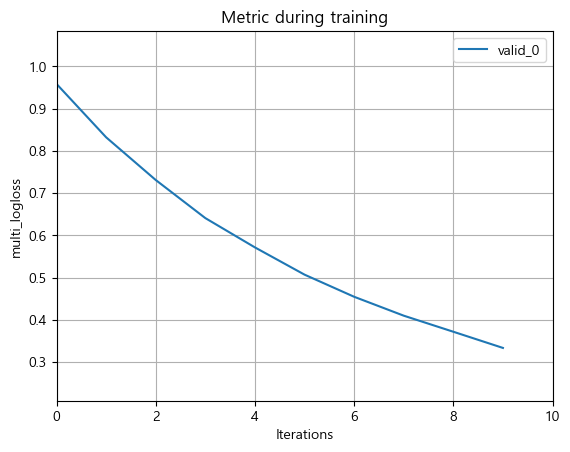

In [171]:
plot_metric(model)

- California Sample(회귀형 샘플)

In [172]:
california = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(california.data, california.target, random_state=42)

In [173]:
model = LGBMRegressor(n_estimators=100)
model.fit(X_train, y_train, early_stopping_rounds=100,
          eval_metric="logloss", eval_set=[(X_test, y_test)],
         verbose = True)
# fit이라는 함수 안에는 사실 반복문처럼 반복실행을 하고 있다
# 어느정도 변화가 없을 때 중지를 시키기 위한 옵션 = early_stopping_rounds
# early_stopping_rounds=100 : 100번 돌 때까지 변화가 없으면 중지시키겠다

[1]	valid_0's l2: 1.16283
[2]	valid_0's l2: 1.02756
[3]	valid_0's l2: 0.916963
[4]	valid_0's l2: 0.821253
[5]	valid_0's l2: 0.746683
[6]	valid_0's l2: 0.681512
[7]	valid_0's l2: 0.622827
[8]	valid_0's l2: 0.574682
[9]	valid_0's l2: 0.534902
[10]	valid_0's l2: 0.50245
[11]	valid_0's l2: 0.472656
[12]	valid_0's l2: 0.448665
[13]	valid_0's l2: 0.427001
[14]	valid_0's l2: 0.407672
[15]	valid_0's l2: 0.393788
[16]	valid_0's l2: 0.379775
[17]	valid_0's l2: 0.3662
[18]	valid_0's l2: 0.355743
[19]	valid_0's l2: 0.345494
[20]	valid_0's l2: 0.337253
[21]	valid_0's l2: 0.327643
[22]	valid_0's l2: 0.319412
[23]	valid_0's l2: 0.311759
[24]	valid_0's l2: 0.305131
[25]	valid_0's l2: 0.297484
[26]	valid_0's l2: 0.292113
[27]	valid_0's l2: 0.285865
[28]	valid_0's l2: 0.280194
[29]	valid_0's l2: 0.275744
[30]	valid_0's l2: 0.271333
[31]	valid_0's l2: 0.267862
[32]	valid_0's l2: 0.265065
[33]	valid_0's l2: 0.262503
[34]	valid_0's l2: 0.260544
[35]	valid_0's l2: 0.259157
[36]	valid_0's l2: 0.256226
[37]	v

LGBMRegressor()

In [174]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8848589288363256
0.8388070733850864


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

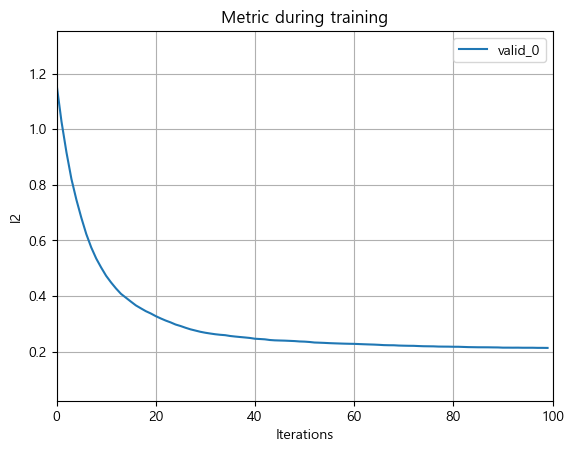

In [175]:
plot_metric(model)

- 당뇨병 샘플(회귀용)

In [176]:
diabets = load_diabetes()

X_train, X_test, y_train, y_test = train_test_split(diabets.data, diabets.target, random_state=42)

In [185]:
model1 = LGBMRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)
model1.fit(X_train, y_train, early_stopping_rounds=100,
          eval_metric="logloss", eval_set=[(X_test, y_test)],
         verbose = True)
# fit이라는 함수 안에는 사실 반복문처럼 반복실행을 하고 있다
# 어느정도 변화가 없을 때 중지를 시키기 위한 옵션 = early_stopping_rounds
# early_stopping_rounds=100 : 100번 돌 때까지 변화가 없으면 중지시키겠다

[1]	valid_0's l2: 5191.36
[2]	valid_0's l2: 4864.92
[3]	valid_0's l2: 4511.2
[4]	valid_0's l2: 4254.74
[5]	valid_0's l2: 4037.41
[6]	valid_0's l2: 3811.27
[7]	valid_0's l2: 3665.43
[8]	valid_0's l2: 3504.05
[9]	valid_0's l2: 3417.61
[10]	valid_0's l2: 3296.34
[11]	valid_0's l2: 3227.1
[12]	valid_0's l2: 3133.17
[13]	valid_0's l2: 3115.54
[14]	valid_0's l2: 3031.15
[15]	valid_0's l2: 3014.51
[16]	valid_0's l2: 2986.93
[17]	valid_0's l2: 2943.4
[18]	valid_0's l2: 2909.59
[19]	valid_0's l2: 2914
[20]	valid_0's l2: 2914.83
[21]	valid_0's l2: 2869.06
[22]	valid_0's l2: 2866.2
[23]	valid_0's l2: 2837.45
[24]	valid_0's l2: 2814.37
[25]	valid_0's l2: 2817.53
[26]	valid_0's l2: 2820.99
[27]	valid_0's l2: 2811.85
[28]	valid_0's l2: 2795.42
[29]	valid_0's l2: 2780.58
[30]	valid_0's l2: 2752
[31]	valid_0's l2: 2755.84
[32]	valid_0's l2: 2755.21
[33]	valid_0's l2: 2755.6
[34]	valid_0's l2: 2743.86
[35]	valid_0's l2: 2742.14
[36]	valid_0's l2: 2725.46
[37]	valid_0's l2: 2720.37
[38]	valid_0's l2: 27

LGBMRegressor(max_depth=2, n_estimators=500)

In [186]:
print(model1.score(X_train, y_train))
print(model1.score(X_test, y_test))

0.6376263350783249
0.521161229211471


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

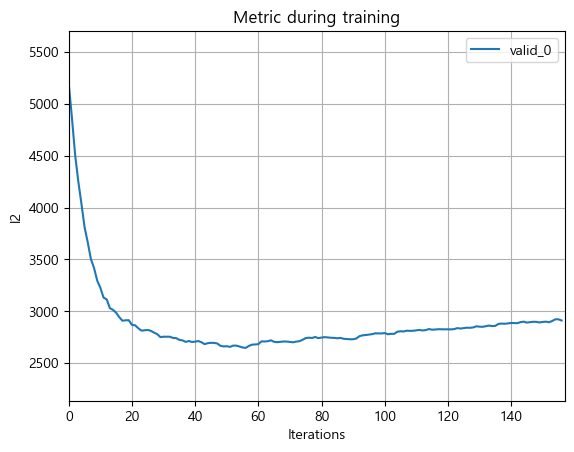

In [187]:
plot_metric(model1)

# 6. Stacking 실습

In [188]:
X_train = pd.read_csv("data/X_final_C.csv")
X_test = pd.read_csv("data/test_final_C.csv")
y_train = pd.read_csv("data/y_train_C.csv")
y_test = pd.read_csv("data/y_test_C.csv")

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [192]:
estimators = [("rf", RandomForestClassifier(n_estimators=10, random_state=42)),
             ("svm", SVC(random_state=42))]

model = StackingClassifier(estimators=estimators,
                           final_estimator = LogisticRegression())
model.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr', SVC(random_state=42))],
                   final_estimator=LogisticRegression())

In [194]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8690647482014389
0.7788944723618091
